<a href="https://colab.research.google.com/github/Mario-bgt/ComptonSim/blob/main/Group_project/Solar_Irradiance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# !Install, Imports & Dataset Loading

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install scikit-learn catboost
!pip install astral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To run before accessing the data. Just access with your google account.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import calendar
import astral
from scipy.signal import correlate
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from astral import LocationInfo
from astral.sun import sun
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Access the files stored on google drive

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Solar Radiation Prediction - ESC 403')

Load the datasets

In [ ]:
df_zurich = pd.read_csv("Zurich.csv", sep=';')
df_dijon = pd.read_csv("Dijon.csv", sep=';')
df_milano = pd.read_csv("Milano.csv", sep=';')
df_innsbruck = pd.read_csv("Innsbruck.csv", sep=';')
df_karlsruhe = pd.read_csv("Karlsruhe.csv", sep=';')

# Data Cleaning & Augmentation

## Dataset Clipping
We clip the dataset to row 78888, i.e., 31/12/2021, as the measurements for solar radiation of 2022 are still not accurate on NASA platform.

In [ ]:
df_zurich = df_zurich.iloc[:78888]
df_dijon = df_dijon.iloc[:78888]
df_milano = df_milano.iloc[:78888]
df_innsbruck = df_innsbruck.iloc[:78888]
df_karlsruhe = df_karlsruhe.iloc[:78888]
dfs = [df_zurich, df_dijon, df_milano, df_innsbruck, df_karlsruhe]
cities = ['Zurich', 'Dijon', 'Milano', 'Innsbruck', 'Karlsruhe']

## Missing Values
We check for Missing (Nan) Values and we see that we have none.

In [ ]:
for city, df in zip(cities, dfs):
    a = max(df.isna().sum())
    print(f'The amount of rows with NaN values for {city} are: {a} \n')

The amount of rows with NaN values for Zurich are: 0 

The amount of rows with NaN values for Dijon are: 0 

The amount of rows with NaN values for Milano are: 0 

The amount of rows with NaN values for Innsbruck are: 0 

The amount of rows with NaN values for Karlsruhe are: 0 



## Data Augmentation
We use Astral library to add a "Time of Sunrise" and "Time of Sunset" column to each dataset.

In [ ]:
zurich = LocationInfo("Zurich", "Switzerland", "Europe", 47.3557, 8.5555)
dijon = LocationInfo("Dijon", "France", "Europe", 47.3273, 5.0591)
milano = LocationInfo("Milan", "Italy", "Europe", 45.4882, 9.2297)
innsbruck = LocationInfo("Innsbruck", "Austria", "Europe", 47.2677, 11.4119)
karlsruhe = LocationInfo("Karlsruhe", "Germany", "Europe", 48.9943, 8.4346)
cities = [zurich, dijon, milano, innsbruck, karlsruhe]

for city, df in zip(cities, dfs):
    time_sunrise, time_sunset = [], []
    for year in range(2013, 2022):
        for month in range(1, 13):
            if month in [11, 4, 6, 9]:
                for day in range(1, 31):
                    time_sunrise.append(sun(city.observer, date=datetime.date(year, month, day))["sunrise"])
                    time_sunset.append(sun(city.observer, date=datetime.date(year, month, day))["sunset"])
            if month == 2: 
                if year in [2016, 2020]:
                    for day in range(1,30):
                        time_sunrise.append(sun(city.observer, date=datetime.date(year, month, day))["sunrise"])
                        time_sunset.append(sun(city.observer, date=datetime.date(year, month, day))["sunset"])
                else:
                    for day in range(1,29):
                        time_sunrise.append(sun(city.observer, date=datetime.date(year, month, day))["sunrise"])
                        time_sunset.append(sun(city.observer, date=datetime.date(year, month, day))["sunset"])
            if month in [1, 3, 5, 7, 8, 10, 12]:
                for day in range(1,32):
                    time_sunrise.append(sun(city.observer, date=datetime.date(year, month, day))["sunrise"])
                    time_sunset.append(sun(city.observer, date=datetime.date(year, month, day))["sunset"])
                    
    sunrise = [x for x in time_sunrise for _ in range(24)]
    sunset = [x for x in time_sunset for _ in range(24)]
    df['SUNRISE'] = sunrise
    df['SUNSET'] = sunset

# Data Exploration & Visualization

<Axes: >

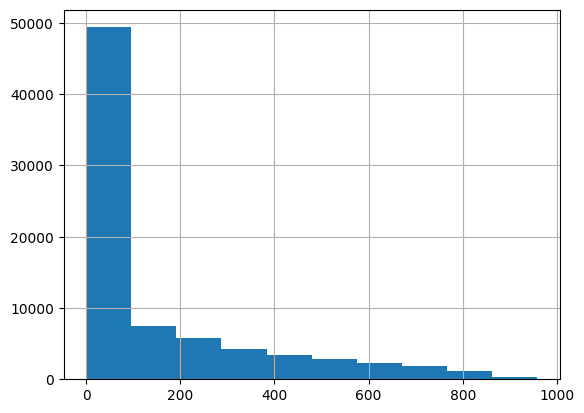

In [ ]:
df_zurich['IRRADIANCE'].hist()


Map Visualization of the 5 locations

In [ ]:
import folium

# Create a map object centered on Europe
map_center = [48.2082, 16.3738]
map_zoom = 5
my_map = folium.Map(location=map_center, zoom_start=map_zoom)

# Define the locations we want to plot
locations = {
    "Zurich": [47.35, 8.55],
    "Milan": [45.47, 9.18],
    "Karlsruhe": [48.99, 8.43],
    "Dijon": [47.32, 5.06],
    "Innsbruck": [47.27, 11.43],
}

# Add markers for each location to the map
for location_name, location in locations.items():
    folium.Marker(
        location=location,
        tooltip=location_name,
        icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(my_map)

# Display the map
#my_map

In [ ]:
for city, df in zip(cities, dfs):
    print(f'The correlation of features with target variable for {city} are: \n')
    print(df.corr()["IRRADIANCE"].sort_values(ascending = False))
    print()
    print()

The correlation of features with target variable for LocationInfo(name='Zurich', region='Switzerland', timezone='Europe', latitude=47.3557, longitude=8.5555) are: 

IRRADIANCE              1.000000
TEMPERATURE             0.529656
WET BULB TEMPERATURE    0.447659
HUMIDITY                0.351225
DEW                     0.340066
PRESSURE                0.080217
WIND SPEED              0.075172
HOUR                    0.040638
YEAR                    0.018283
WIND DIRECTION          0.015637
DAY                     0.010303
MONTH                  -0.042923
PRECIPITATION          -0.103425
Name: IRRADIANCE, dtype: float64


The correlation of features with target variable for LocationInfo(name='Dijon', region='France', timezone='Europe', latitude=47.3273, longitude=5.0591) are: 

IRRADIANCE              1.000000
TEMPERATURE             0.556953
WET BULB TEMPERATURE    0.438783
HUMIDITY                0.277130
DEW                     0.266124
PRESSURE                0.084136
WIND SPEED    

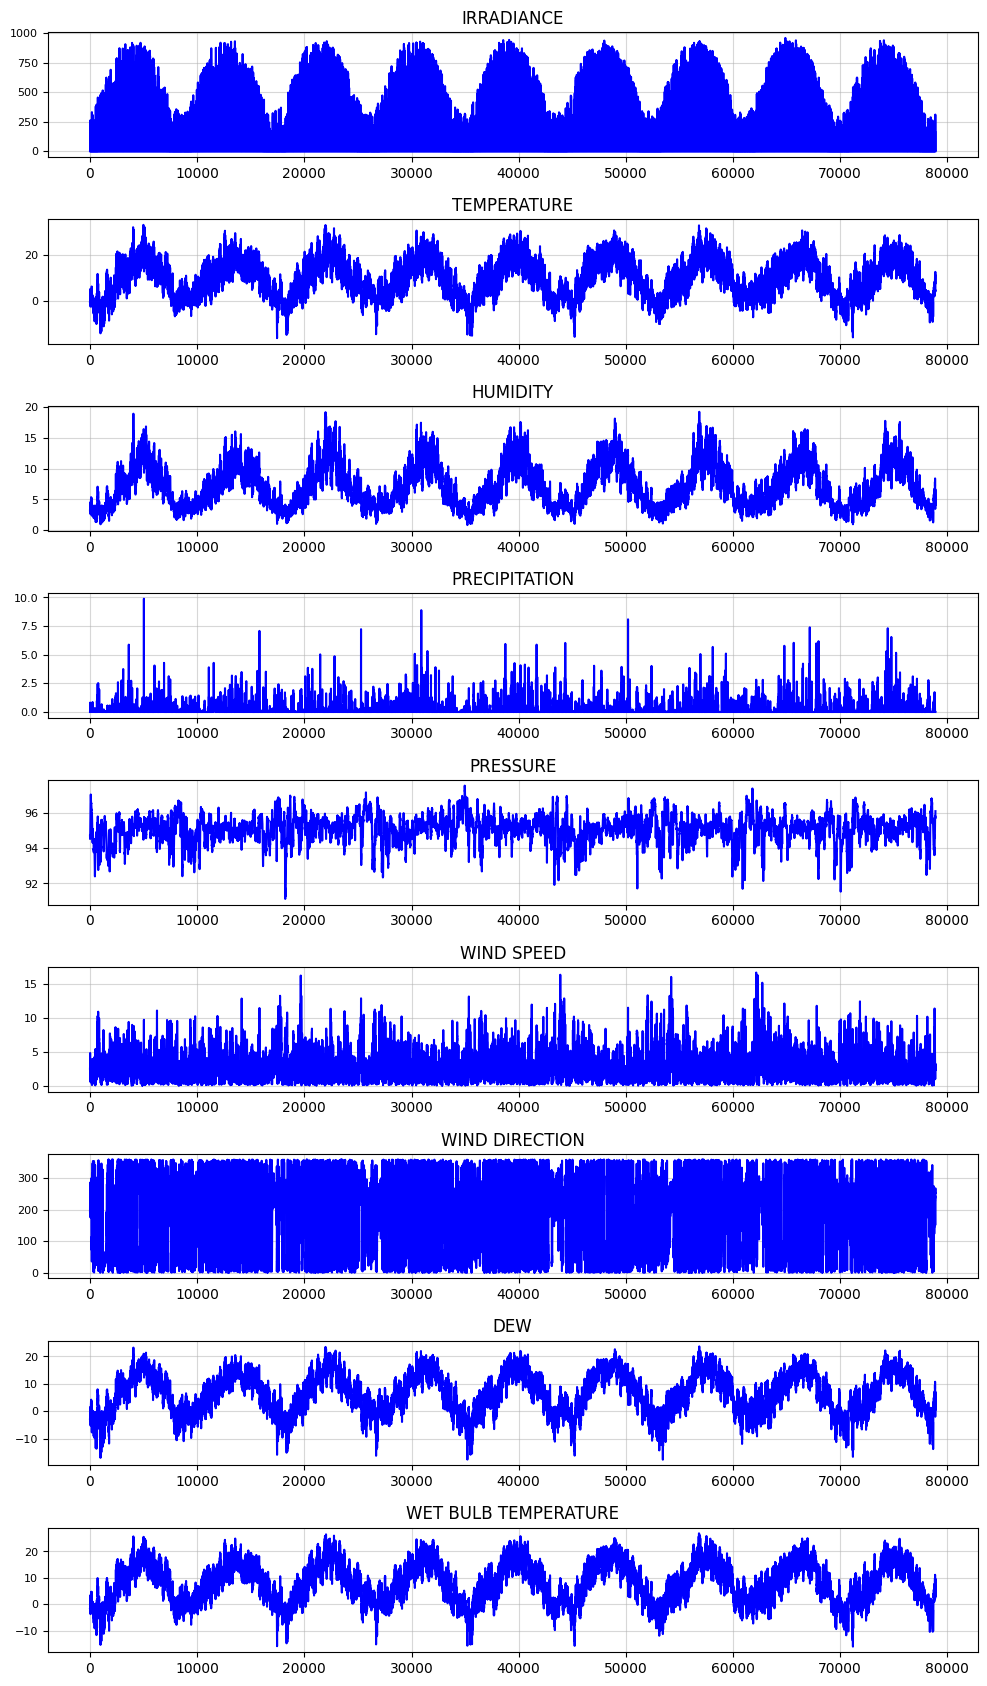

In [ ]:
# create figure with subplots for each feature
fig, axs = plt.subplots(nrows=9, figsize=(12, 18))

# loop over each feature and create a subplot
for i, feature in enumerate(['IRRADIANCE', 'TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE']):
    axs[i].plot(df_zurich[feature], color='mediumblue')
    axs[i].set_title(feature, fontsize=12)
    axs[i].tick_params(axis='y', labelsize=8)
    axs[i].grid(True, alpha=0.5)

# adjust spacing between subplots
fig.subplots_adjust(hspace=0.5, top=0.95, bottom=0.05)
fig.savefig('scatter_plot_matrix.jpeg')
fig.savefig('scatter_plot_matrix.pdf')

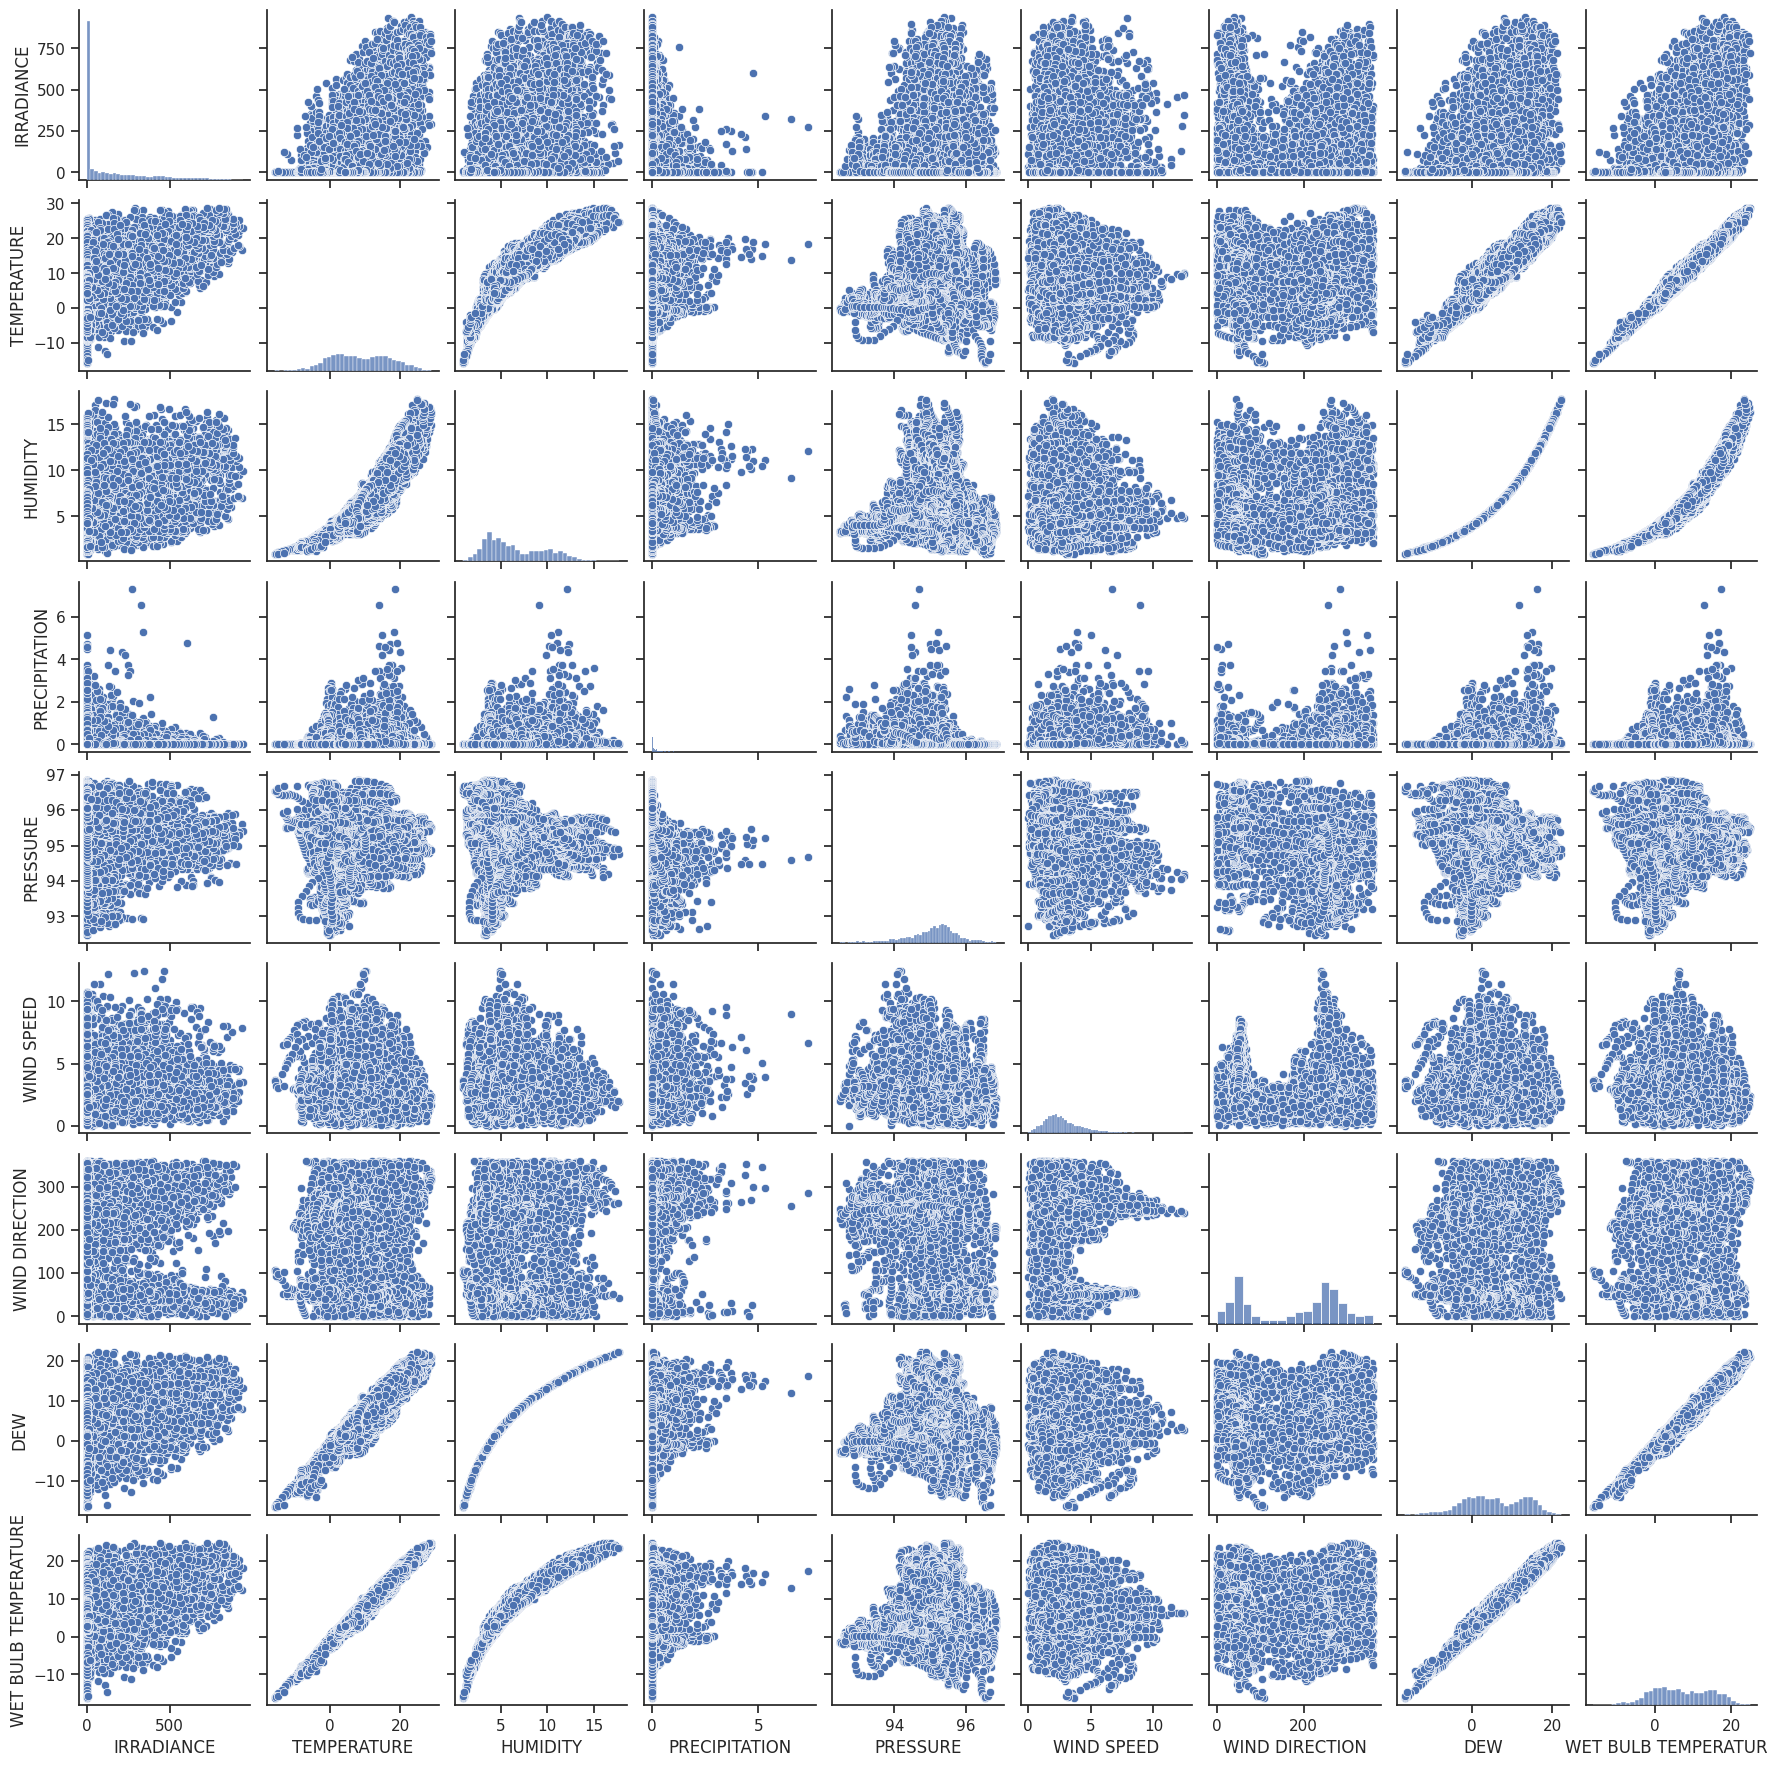

In [ ]:
# Possible plot for the project description?
# Filter data for year 2021 of Zürich
df_zurich_2021 = df_zurich[df_zurich['YEAR'] == 2021]

# Select columns to include in the scatter plot matrix
cols = ['IRRADIANCE', 'TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE']

# Create the scatter plot matrix using seaborn
sns.set(style='ticks')
g = sns.pairplot(df_zurich_2021[cols], diag_kind='hist', height=2)

# Save the plot as a PDF and JPEG file
g.savefig('scatter_plot_matrix.jpeg')
g.savefig('scatter_plot_matrix.pdf')

In [ ]:
# a pairplot for the whole dataset


# Filter data for year 2021 of Zürich
df_zurich_2021 = df_zurich[df_zurich['YEAR'] == 2021]

# Select columns to include in the scatter plot matrix
cols = ['IRRADIANCE', 'TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE']

# Create the scatter plot matrix using seaborn
sns.set(style='ticks')
g = sns.pairplot(df_zurich_2021[cols], diag_kind='hist', height=2)

# Save the plot as a PDF and JPEG file
g.savefig('scatter_plot_matrix.jpeg')
g.savefig('scatter_plot_matrix.pdf')

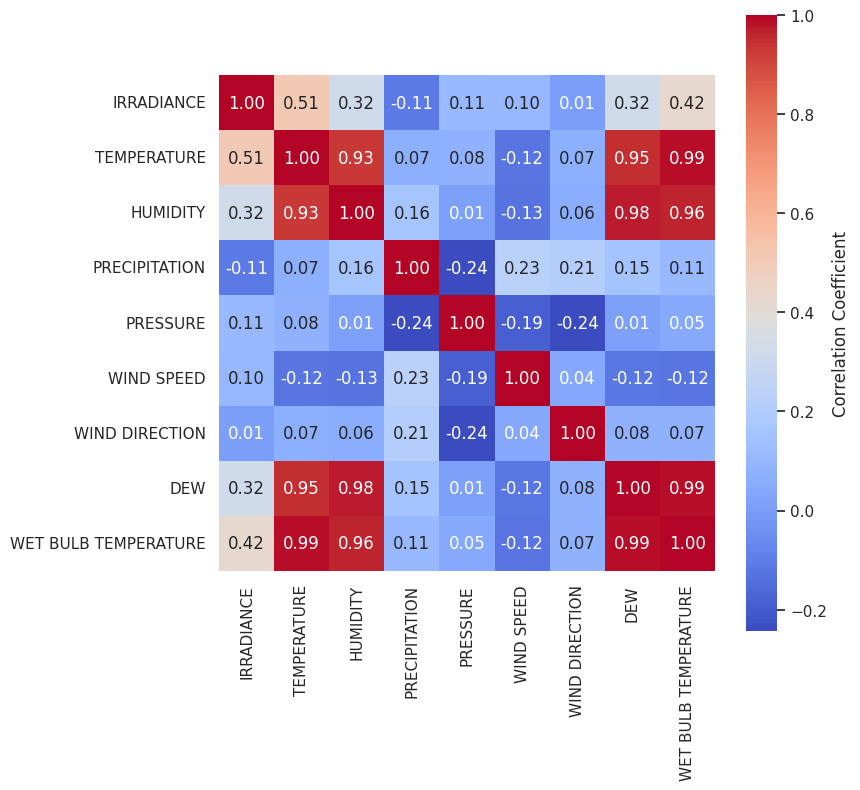

In [ ]:
corr = df_zurich_2021[cols].corr()
sns.set(style='white')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(corr, square=True, cmap='coolwarm', annot=True, fmt=".2f",
                     cbar_kws={'label': 'Correlation Coefficient'})

# Save the plot as a PDF and JPEG file
f.savefig('correlation_matrix.jpeg', bbox_inches="tight")
f.savefig('correlation_matrix.pdf', bbox_inches="tight")

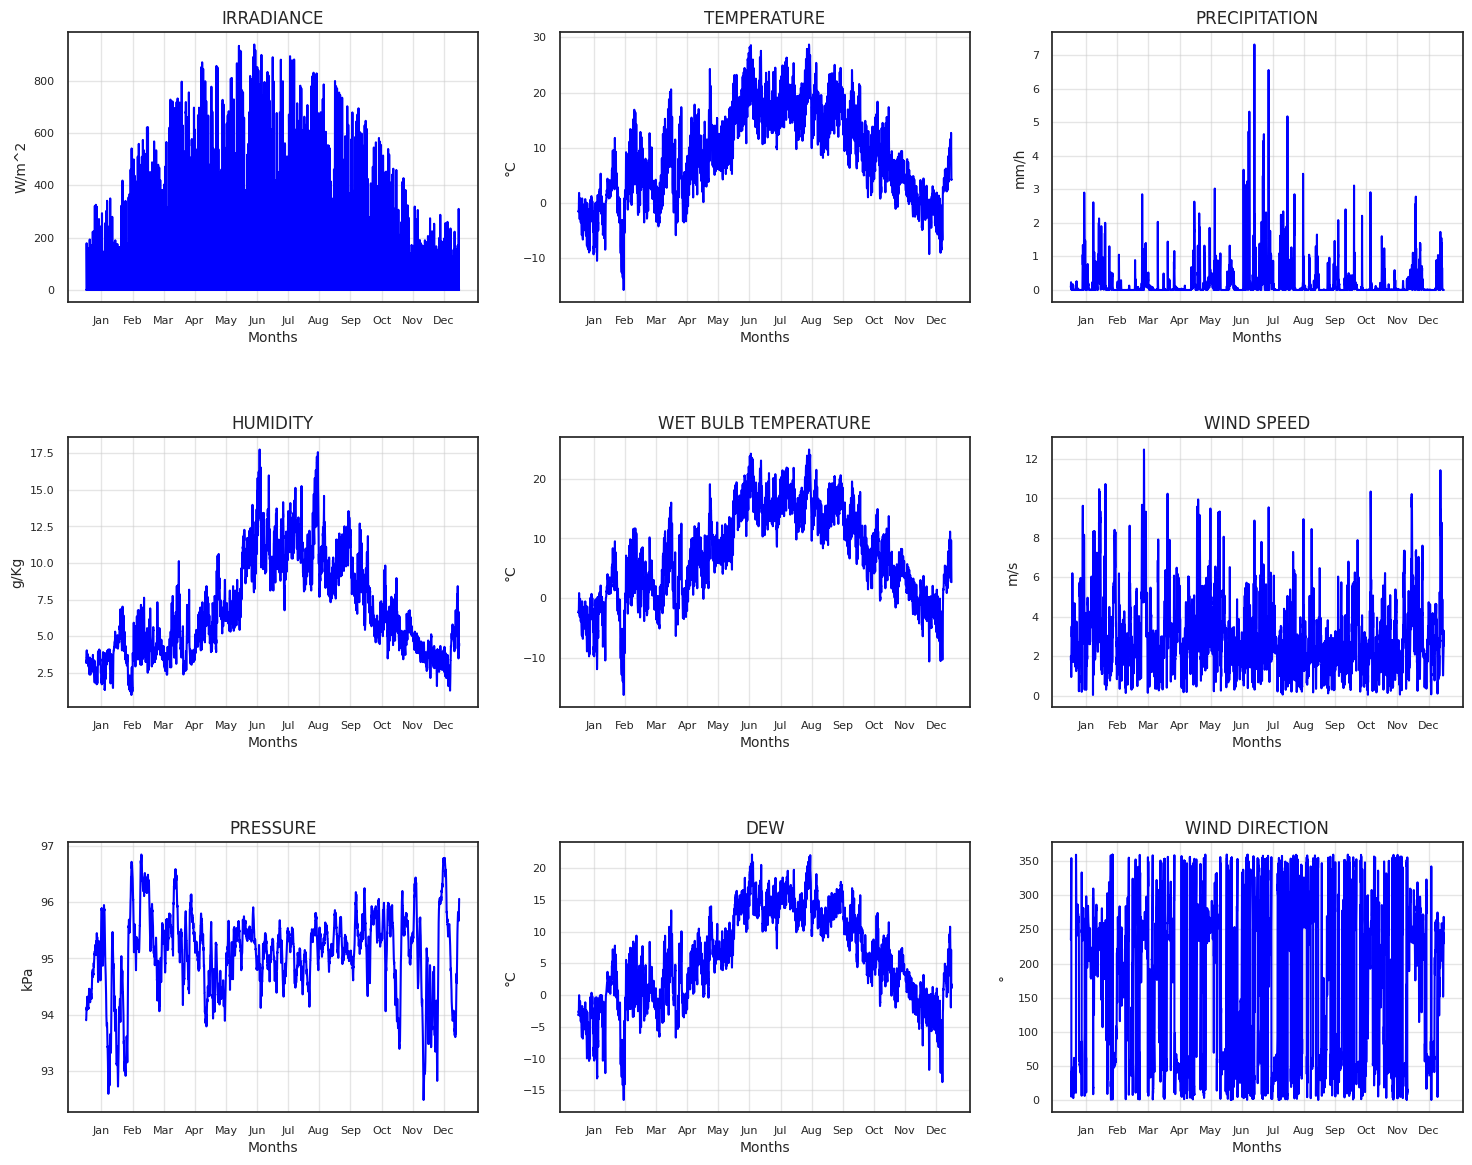

In [ ]:
# create figure with subplots for each feature
fig = plt.figure(figsize=(18, 12))
ticks = np.linspace(70127+24*15, 78886-24*15, 12)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y_labels = ['W/m^2', '°C', 'mm/h', 'g/Kg', '°C', 'm/s', 'kPa', '°C', '°' ]

# loop over each feature and create a subplot
for i, feature in enumerate(['IRRADIANCE', 'TEMPERATURE',  'PRECIPITATION','HUMIDITY', 'WET BULB TEMPERATURE','WIND SPEED', 'PRESSURE',  'DEW', 'WIND DIRECTION' ]):
    row = i // 3
    col = i % 3
    axs = fig.add_subplot(3, 3, i+1)
    axs.plot(df_zurich_2021[feature], color='blue')
    axs.set_title(feature, fontsize=12)
    axs.set_xlabel('Months', fontsize=10)
    axs.set_ylabel(y_labels[i], fontsize=10)
    axs.set_xticks(ticks)
    axs.set_xticklabels(months, fontsize=8)
    axs.tick_params(axis='y', labelsize=8)
    axs.grid(True, alpha=0.5)


# adjust spacing between subplots
fig.subplots_adjust(hspace=0.5, top=0.95, bottom=0.05)
fig.savefig('Plot_for_each_feature.jpeg')
fig.savefig('Plot_for_each_feature.pdf')

In [ ]:
# split the zurich dataset in subsets for each year
df_zurich_2013 = df_zurich[df_zurich['YEAR'] == 2013].reset_index(drop=True)
df_zurich_2014 = df_zurich[df_zurich['YEAR'] == 2014].reset_index(drop=True)
df_zurich_2015 = df_zurich[df_zurich['YEAR'] == 2015].reset_index(drop=True)
df_zurich_2016 = df_zurich[df_zurich['YEAR'] == 2016].reset_index(drop=True)
df_zurich_2017 = df_zurich[df_zurich['YEAR'] == 2017].reset_index(drop=True)
df_zurich_2018 = df_zurich[df_zurich['YEAR'] == 2018].reset_index(drop=True)
df_zurich_2019 = df_zurich[df_zurich['YEAR'] == 2019].reset_index(drop=True)
df_zurich_2020 = df_zurich[df_zurich['YEAR'] == 2020].reset_index(drop=True)
df_zurich_2021 = df_zurich[df_zurich['YEAR'] == 2021].reset_index(drop=True)

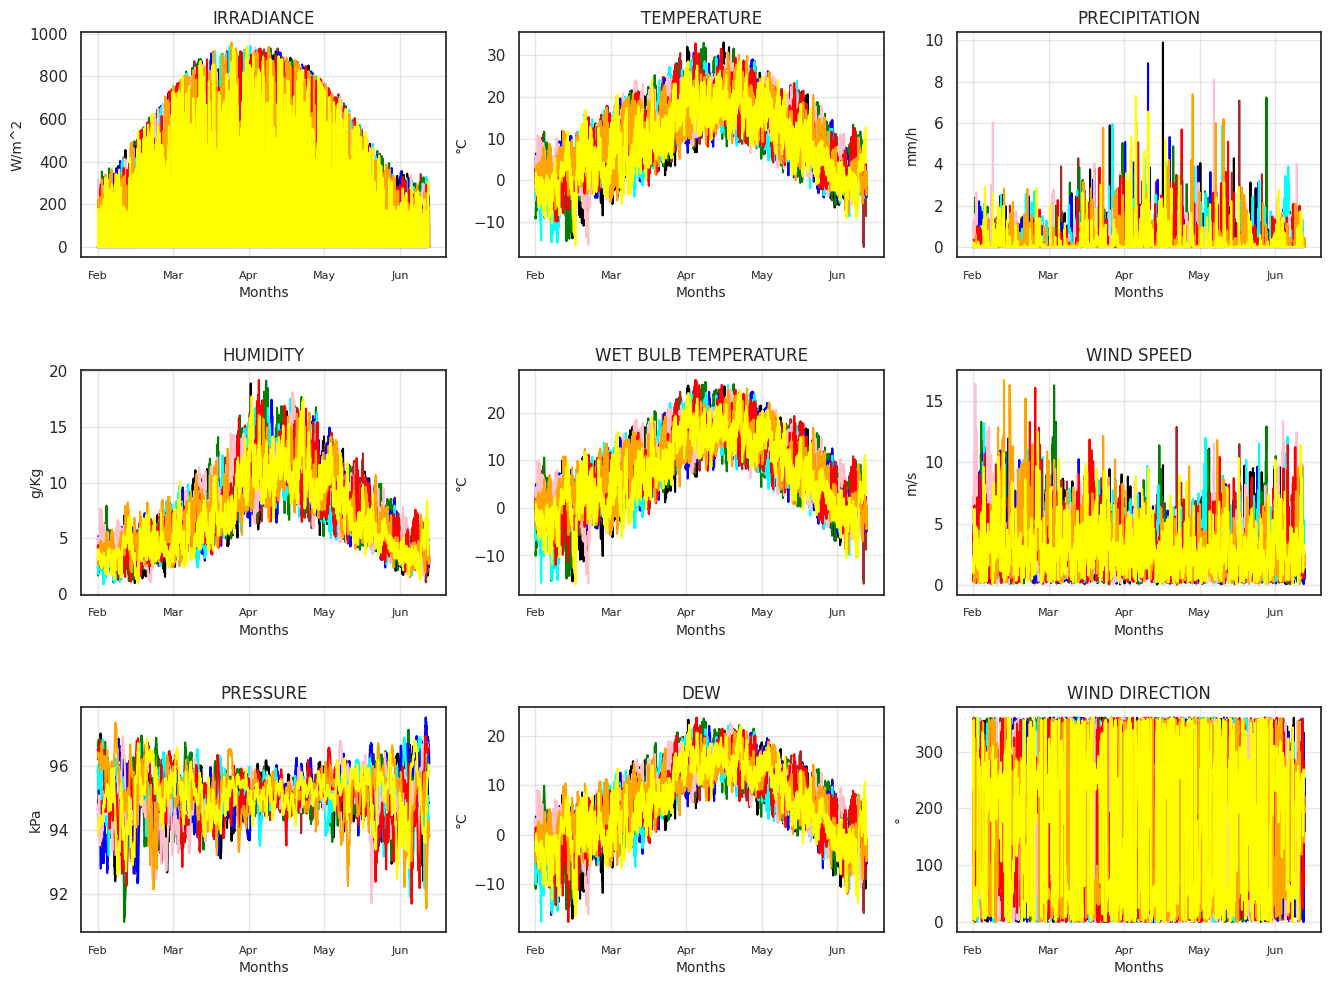

In [ ]:
# create figure with subplots for each feature
fig = plt.figure(figsize=(16,10))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y_labels = ['W/m^2', '°C', 'mm/h', 'g/Kg', '°C', 'm/s', 'kPa', '°C', '°' ]

# loop over each feature and create a subplot
for i, feature in enumerate(['IRRADIANCE', 'TEMPERATURE',  'PRECIPITATION','HUMIDITY', 'WET BULB TEMPERATURE','WIND SPEED', 'PRESSURE',  'DEW', 'WIND DIRECTION' ]):
    row = i // 3
    col = i % 3
    axs = fig.add_subplot(3, 3, i+1)

    axs.plot(df_zurich_2013[feature], color='black')
    axs.plot(df_zurich_2014[feature], color='brown')
    axs.plot(df_zurich_2015[feature], color='green')
    axs.plot(df_zurich_2016[feature], color='blue')
    axs.plot(df_zurich_2017[feature], color='cyan')
    axs.plot(df_zurich_2018[feature], color='pink')
    axs.plot(df_zurich_2019[feature], color='red')
    axs.plot(df_zurich_2020[feature], color='orange')
    axs.plot(df_zurich_2021[feature], color='yellow')

    axs.set_title(feature, fontsize=12)
    axs.set_xlabel('Months', fontsize=10)
    axs.set_ylabel(y_labels[i], fontsize=10)
    axs.set_xticklabels(months, fontsize=8)
    axs.grid(True, alpha=0.5)


# adjust spacing between subplots
fig.subplots_adjust(hspace=0.5, top=0.95, bottom=0.05)
fig.savefig('Plot_for_each_feature_all_years.jpeg')
fig.savefig('Plot_for_each_feature_all_years.pdf')


In [ ]:
# plot the subplots seperately
FIGS = []
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y_labels = ['W/m^2', '°C', 'mm/h', 'g/Kg', '°C', 'm/s', 'kPa', '°C', '°' ]

# loop over each feature and create a subplot
for i, feature in enumerate(['IRRADIANCE', 'TEMPERATURE',  'PRECIPITATION','HUMIDITY', 'WET BULB TEMPERATURE','WIND SPEED', 'PRESSURE',  'DEW', 'WIND DIRECTION' ]):
    figure = plt.figure()
    figure.plot(df_zurich_2013[feature], color='black')
    figure.plot(df_zurich_2014[feature], color='brown')
    figure.plot(df_zurich_2015[feature], color='green')
    figure.plot(df_zurich_2016[feature], color='blue')
    figure.plot(df_zurich_2017[feature], color='cyan')
    figure.plot(df_zurich_2018[feature], color='pink')
    figure.plot(df_zurich_2019[feature], color='red')
    figure.plot(df_zurich_2020[feature], color='orange')
    figure.plot(df_zurich_2021[feature], color='yellow')

    figure.set_title(feature, fontsize=12)
    figure.set_xlabel('Months', fontsize=10)
    figure.set_ylabel(y_labels[i], fontsize=10)
    figure.set_xticklabels(months, fontsize=8)
    figure.grid(True, alpha=0.5)
    FIGS.append(figure)




AttributeError: ignored

<Figure size 640x480 with 0 Axes>

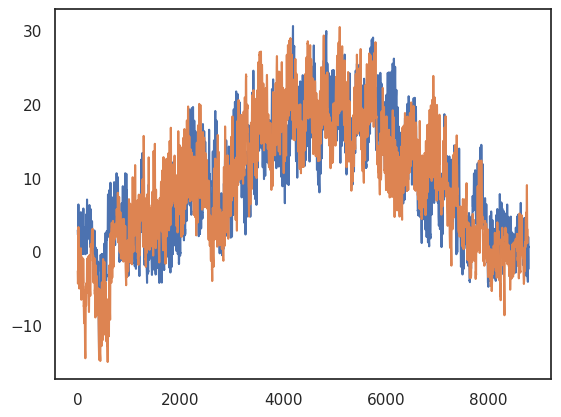

In [ ]:
plt.plot(df_zurich_2016['TEMPERATURE'])
plt.plot(df_zurich_2017['TEMPERATURE'])

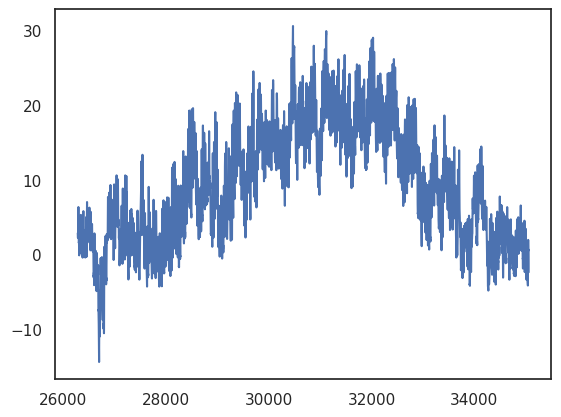

In [ ]:
zurich_14 = df_zurich_2014.reset_index(drop=True)
zurich_14.head()

,YEAR,MONTH,DAY,HOUR,IRRADIANCE,TEMPERATURE,HUMIDITY,PRECIPITATION,PRESSURE,WIND SPEED,WIND DIRECTION,DEW,WET BULB TEMPERATURE
0,2014,1,1,0,0.0,-3.27,2.38,0.00,94.88,3.28,230.61,-6.57,-4.92
1,2014,1,1,1,0.0,-3.24,2.44,0.00,94.91,3.17,225.10,-6.49,-4.87
2,2014,1,1,2,0.0,-2.95,2.44,0.00,94.92,3.02,216.37,-6.40,-4.67
3,2014,1,1,3,0.0,-2.50,2.50,0.02,94.91,2.95,209.48,-6.00,-4.25
4,2014,1,1,4,0.0,-1.32,2.81,0.10,94.92,2.67,205.67,-4.70,-3.01


In [ ]:
df_zurich_2013.tail()

,YEAR,MONTH,DAY,HOUR,IRRADIANCE,TEMPERATURE,HUMIDITY,PRECIPITATION,PRESSURE,WIND SPEED,WIND DIRECTION,DEW,WET BULB TEMPERATURE
8754,2013,12,31,19,0.0,-1.46,2.69,0.0,94.89,2.34,165.50,-5.23,-3.35
8755,2013,12,31,20,0.0,-1.51,2.50,0.0,94.86,2.50,174.98,-6.23,-3.87
8756,2013,12,31,21,0.0,-1.60,2.32,0.0,94.84,2.60,187.94,-6.95,-4.27
8757,2013,12,31,22,0.0,-2.23,2.32,0.0,94.83,2.85,208.89,-7.05,-4.64
8758,2013,12,31,23,0.0,-3.01,2.38,0.0,94.86,3.17,225.30,-6.77,-4.89


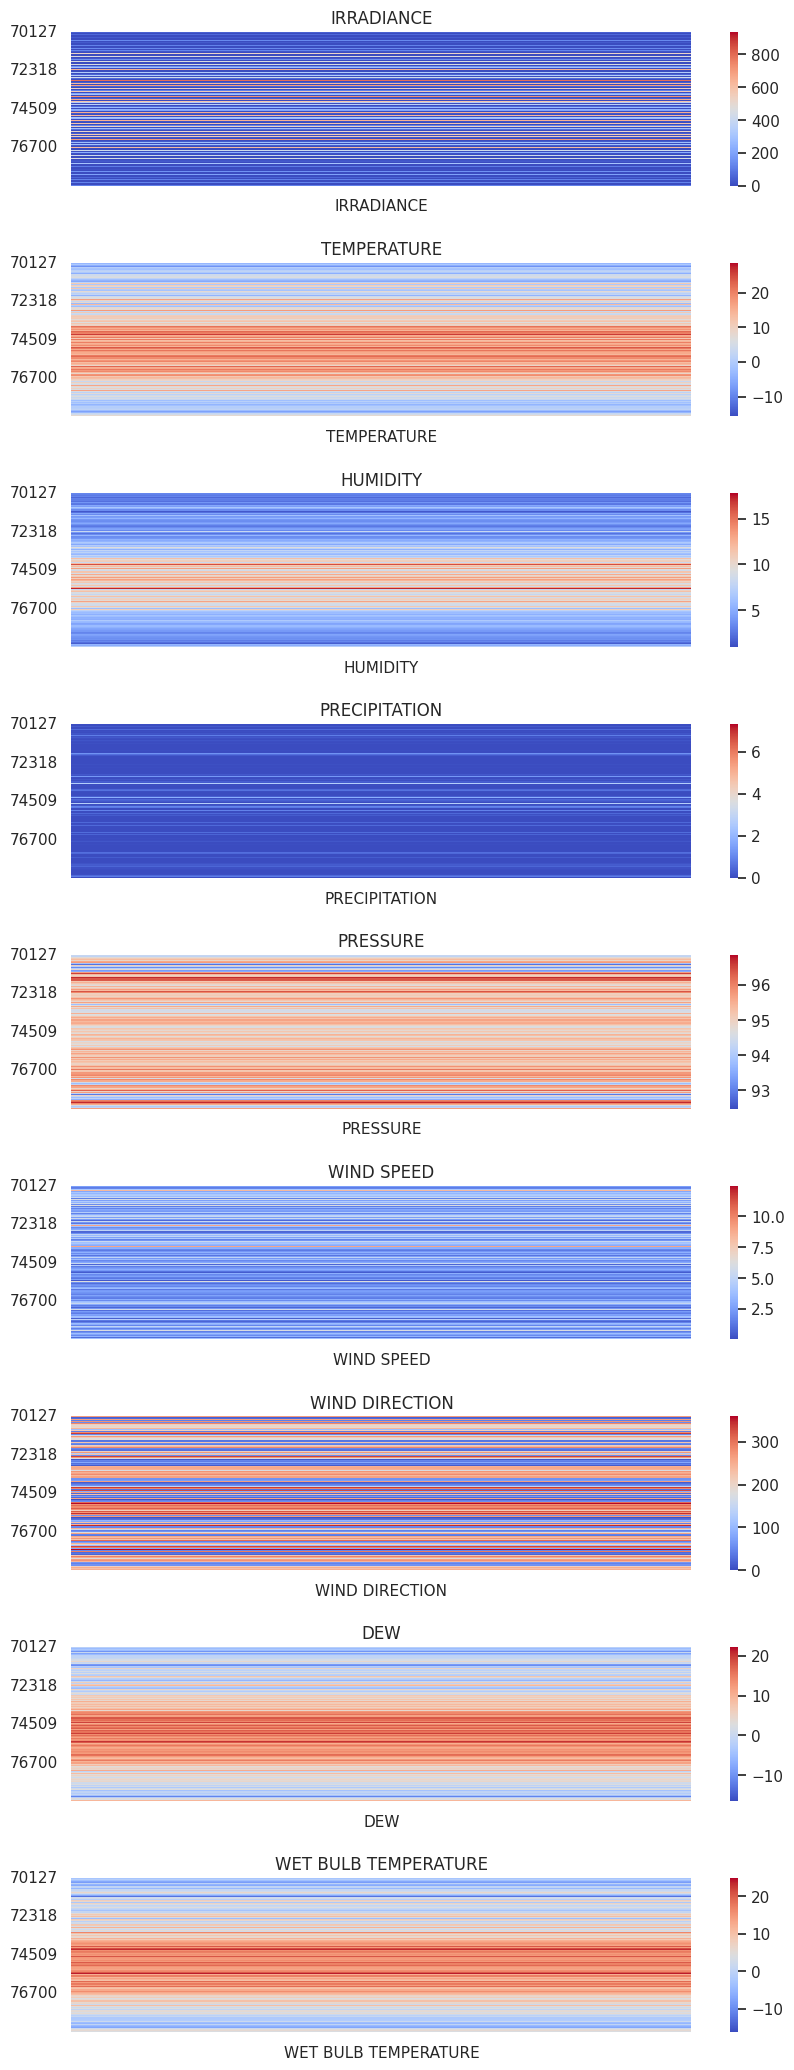

In [ ]:
i# create figure with subplots for each feature
fig, axs = plt.subplots(nrows=9, figsize=(10, 10))

# loop over each feature and create a heatmap
for i, feature in enumerate(['IRRADIANCE', 'TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE']):
    sns.heatmap(df_zurich_2021[[feature]], ax=axs[i], cmap='coolwarm')
    axs[i].set_title(feature)

# adjust spacing between subplots
fig.subplots_adjust(hspace=0.5, top=2, bottom=0)


# Feature Engineering

Transforming the time of sunrise/sunset into ”how much time elapsed after sunrise” (SUNRISE) / ”how much time till sunset” (SUNSET) and "LIGHT", i.e., a binary variable indicating whether the sun is up or not at that specific measurement time. 

In [ ]:
dfs = [df_zurich, df_dijon, df_milano, df_innsbruck, df_karlsruhe]
for df in dfs:
  df['TIME'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR']])
  df["TIME"] = df["TIME"].apply(lambda x: int(x.timestamp()))
  df["SUNRISE"] = df["SUNRISE"].apply(lambda x: int(x.timestamp()))
  df["SUNSET"] = df["SUNSET"].apply(lambda x: int(x.timestamp()))
  df["SUNRISE"] = df["TIME"] - df["SUNRISE"]
  df["SUNSET"] = df["TIME"] - df["SUNSET"]
  df['LIGHT'] = np.where(np.sign(df['SUNRISE']) != np.sign(df['SUNSET']), 1, 0)

df_zurich = df_zurich.drop("TIME", axis = 1)
df_dijon = df_dijon.drop("TIME", axis = 1)
df_milano = df_milano.drop("TIME", axis = 1)
df_innsbruck = df_innsbruck.drop("TIME", axis = 1)
df_karlsruhe = df_karlsruhe.drop("TIME", axis = 1)

Normalization of the following columns:


*   Temperature
*   Humidity
*   Precipitation
*   Pressure
*   Wind Speed
*   Dew
*   Wet Bulb Temperature




In [ ]:
cols_to_normalize = ['TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'DEW', 'WET BULB TEMPERATURE']
scaler = MinMaxScaler()

# Model Selection and Prediction Pipeline

## Classical ML Algorithms



*   Linear Regression
*   K-Nearest Neighbhor Regression (KNN)
*   Decision Tree Regression
*   Random Forest Regression
*   Extreme Gradient Boosting (XGB)
*   AdaBoost
*   CatBoost

In [ ]:
pred_cities = ['pred_zurich', 'pred_dijon', 'pred_milano', 'pred_innsbruck', 'pred_karlsruhe']
cities = ['Zurich', 'Dijon', 'Milano', 'Innsbruck', 'Karlsruhe']
regressors = [LinearRegression(),
              KNeighborsRegressor(n_neighbors=5, weights='distance'),
              XGBRegressor(subsample = 1.0, n_jobs = -1, n_estimators = 362, max_depth = 7, learning_rate = 0.06),
              LGBMRegressor(max_depth=15, learning_rate=0.05, n_estimators=350, n_jobs=-1),
              DecisionTreeRegressor(),
              RandomForestRegressor(n_jobs = -1, n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 5, max_depth = 20),
              AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42),
              CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, loss_function='RMSE', random_seed=42, verbose=0)]

for city, df in zip(cities,dfs):
    print()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    X = df.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET'])
    y = df['IRRADIANCE']

    for model in regressors:
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        print(f'({city} {type(model).__name__}) MSE: {scores}, Mean MSE: {np.mean(scores)}')


(Zurich LinearRegression) MSE: [-14901.6068057  -14827.86354568 -14704.1263652  -15190.01762869
 -14999.98833839], Mean MSE: -14924.720536731558
(Zurich KNeighborsRegressor) MSE: [-2774.68741163 -2763.83144754 -2806.38609903 -2846.35221149
 -2878.35501468], Mean MSE: -2813.922436873854
(Zurich XGBRegressor) MSE: [-1460.04166478 -1584.70079162 -1482.10121611 -1610.33239067
 -1518.16288306], Mean MSE: -1531.067789248939
(Zurich LGBMRegressor) MSE: [-1649.7147319  -1801.61939205 -1708.44955326 -1842.46289349
 -1713.05831518], Mean MSE: -1743.0609771764437
(Zurich DecisionTreeRegressor) MSE: [-3459.41765002 -3622.77270249 -3364.65686051 -3769.22998851
 -3526.04680854], Mean MSE: -3548.4248020154273
(Zurich RandomForestRegressor) MSE: [-1774.28378323 -1869.88638038 -1813.24752349 -1896.42939535
 -1845.6724675 ], Mean MSE: -1839.9039099918075
(Zurich AdaBoostRegressor) MSE: [-1474.90814223 -1568.32796901 -1475.89121043 -1590.6890445
 -1542.92883302], Mean MSE: -1530.5490398361962
(Zurich Ca

(Zurich LinearRegression) MSE: [-14901.6068057  -14827.86354568 -14704.1263652  -15190.01762869
 -14999.98833839], Mean MSE: -14924.720536731558

(Zurich KNeighborsRegressor) MSE: [-2774.68741163 -2763.83144754 -2806.38609903 -2846.35221149
 -2878.35501468], Mean MSE: -2813.922436873854

(Zurich XGBRegressor) MSE: [-1460.04166478 -1584.70079162 -1482.10121611 -1610.33239067
 -1518.16288306], Mean MSE: -1531.067789248939

(Zurich DecisionTreeRegressor) MSE: [-3368.96364951 -3643.80736392 -3385.10631675 -3764.47987704
 -3510.59348787], Mean MSE: -3534.5901390159074

(Zurich RandomForestRegressor) MSE: [-1771.68734849 -1847.59708155 -1740.37024496 -1910.66001349
 -1823.41429668], Mean MSE: -1818.7457970354346

(Zurich AdaBoostRegressor) MSE: [-1474.90814223 -1568.32796901 -1475.89121043 -1590.6890445
 -1542.92883302], Mean MSE: -1530.5490398361962
 
(Zurich CatBoostRegressor) MSE: [-2413.65208798 -2568.56485888 -2493.35691656 -2646.07697558
 -2491.08723594], Mean MSE: -2522.5476149879914

(Dijon LinearRegression) MSE: [-14516.60852137 -14534.45136791 -14436.78059836 -14668.11481787
 -14525.02767664], Mean MSE: -14536.196596429529
(Dijon KNeighborsRegressor) MSE: [-2903.50654726 -2851.62018029 -2917.87415072 -2996.22485951
 -3042.26394143], Mean MSE: -2942.2979358408434
(Dijon XGBRegressor) MSE: [-1721.02280707 -1705.95962407 -1675.31872867 -1757.69095665
 -1677.20500703], Mean MSE: -1707.4394246997992
(Dijon DecisionTreeRegressor) MSE: [-3804.08321757 -3902.32718481 -3906.3254173  -4191.90092301
 -3849.06930141], Mean MSE: -3930.741208818917
(Dijon RandomForestRegressor) MSE: [-1961.66786869 -1997.87663952 -1938.51987884 -2037.99442996
 -1954.23606737], Mean MSE: -1978.0589768764742
(Dijon AdaBoostRegressor) MSE: [-1681.65728066 -1697.68583036 -1631.89413766 -1826.36716849
 -1715.98373434], Mean MSE: -1710.717630300454
(Dijon CatBoostRegressor) MSE: [-2859.76654901 -2817.46191442 -2782.07648477 -2866.12231257
 -2731.59759021], Mean MSE: -2811.404970195773

(Milano LinearRegression) MSE: [-17325.52821443 -17526.04557142 -17038.3303822  -17402.62906671
 -17680.53470893], Mean MSE: -17394.613588736906
(Milano KNeighborsRegressor) MSE: [-3266.99667674 -3420.80170815 -3265.94565627 -3455.78244933
 -3483.69099051], Mean MSE: -3378.643496200727
(Milano XGBRegressor) MSE: [-1578.68455274 -1647.67131659 -1552.79413088 -1569.64566986
 -1626.4309327 ], Mean MSE: -1595.0453205540812
(Milano DecisionTreeRegressor) MSE: [-3842.51962448 -4172.87730944 -3612.54387404 -3955.86377779
 -3764.59963175], Mean MSE: -3869.680843501198
(Milano RandomForestRegressor) MSE: [-1887.59047022 -1901.87553659 -1823.92376274 -1895.97127949
 -1905.80449197], Mean MSE: -1883.0331081999211
(Milano AdaBoostRegressor) MSE: [-1660.85931424 -1635.9214145  -1670.81960914 -1667.46203203
 -1710.917024  ], Mean MSE: -1669.1958787800231
(Milano CatBoostRegressor) MSE: [-2669.20961466 -2762.30108269 -2581.29638284 -2682.80364646
 -2739.57224255], Mean MSE: -2687.036593840923

(Innsbruck LinearRegression) MSE: [-11078.49349658 -11247.2781313  -11067.33274413 -11294.88600007
 -11080.70842277], Mean MSE: -11153.73975897051
(Innsbruck KNeighborsRegressor) MSE: [-2786.2998827  -2809.04794793 -2860.71809393 -2875.79583333
 -2921.32736367], Mean MSE: -2850.6378243114486
(Innsbruck XGBRegressor) MSE: [-1574.47717785 -1668.12648693 -1580.88282788 -1655.98282507
 -1569.12876684], Mean MSE: -1609.7196169133497
(Innsbruck DecisionTreeRegressor) MSE: [-3756.57157104 -3900.70835224 -3731.0189689  -3848.62481735
 -3798.2101567 ], Mean MSE: -3807.0267732446955
(Innsbruck RandomForestRegressor) MSE: [-1910.96542863 -2016.29747062 -1830.25021694 -1987.81523248
 -1948.94543635], Mean MSE: -1938.8547570025646
(Innsbruck AdaBoostRegressor) MSE: [-1625.67973966 -1642.60858736 -1560.9056184  -1717.1371921
 -1603.6054691 ], Mean MSE: -1629.9873213216022
(Innsbruck CatBoostRegressor) MSE: [-2545.54551329 -2676.98265052 -2532.87818657 -2690.71378171
 -2522.58551162], Mean MSE: -2593.7411287428

(Karlsruhe LinearRegression) MSE: [-13495.82286983 -13426.86481185 -13172.90987036 -13472.60694657
 -13300.65621992], Mean MSE: -13373.772143704828
(Karlsruhe KNeighborsRegressor) MSE: [-2615.25722601 -2623.34734432 -2658.22892298 -2734.7945383
 -2737.97407734], Mean MSE: -2673.9204217891297
(Karlsruhe XGBRegressor) MSE: [-1786.8013559  -1796.97050525 -1704.45372909 -1812.59829764
 -1706.0841469 ], Mean MSE: -1761.3816069581512
(Karlsruhe DecisionTreeRegressor) MSE: [-4045.76088834 -4123.27274499 -3866.24356323 -4238.57491979
 -4263.01442047], Mean MSE: -4107.373307363928
(Karlsruhe RandomForestRegressor) MSE: [-2048.78141504 -2007.70370537 -1928.28769795 -2082.91338815
 -1981.89623242], Mean MSE: -2009.9164877868147
(Karlsruhe AdaBoostRegressor) MSE: [-1735.60399832 -1722.70106437 -1624.52843194 -1791.55993011
 -1718.32727669], Mean MSE: -1718.5441402878284
(Karlsruhe CatBoostRegressor) MSE: [-2996.01230978 -2976.58575319 -2824.49363534 -3067.0361038
 -2811.58960859], Mean MSE: -2935.1434821398966

## Ensembling Methods

The best performing models among the classical ones where:


*   Extreme Gradient Boosting (XGB)
*   Random Forest Regressor
*   AdaBoost Regressor

In [ ]:
xgb = XGBRegressor(subsample = 1.0, n_jobs = -1, n_estimators = 362, max_depth = 7, learning_rate = 0.06)
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 5, max_depth = 20)
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42)
elastic_net = ElasticNetCV()
estimators = [('xgb', xgb), ('rf', rf), ('abr', abr)] 

We evaluated three ensemble estimators using the above mentioned base models:

*   Voting Regressor, averaging the predictions of base estimators.
*   Stacking Regressor, with Ridge Regression as final estimator.
*   Stacking Regressor, with Elastic Net Regression as final estimator.

In [ ]:
ensemble_models = [VotingRegressor(estimators, n_jobs=-1),
                   StackingRegressor(estimators, n_jobs=-1),
                   StackingRegressor(estimators, elastic_net, n_jobs=-1)]

cv = KFold(n_splits=3, shuffle=True, random_state=42)
X = df_zurich.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET'])
y = df_zurich['IRRADIANCE']
for model in ensemble_models:
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    print(f'({type(model).__name__}) MSE: {scores}, Mean MSE: {np.mean(scores)}')

(VotingRegressor) MSE: [-1525.66760868 -1552.16791761 -1592.69003383], Mean MSE: -1556.841853369533
(StackingRegressor) MSE: [-1529.67765527 -1550.37923455 -1584.21304729], Mean MSE: -1554.7566457045516
(StackingRegressor) MSE: [-1521.208068   -1543.95807177 -1580.6195616 ], Mean MSE: -1548.595233788392


(VotingRegressor) MSE: [-1525.66760868 -1552.16791761 -1592.69003383], Mean MSE: -1556.841853369533

(StackingRegressor) MSE: [-1529.67765527 -1550.37923455 -1584.21304729], Mean MSE: -1554.7566457045516

(StackingRegressor) MSE: [-1521.208068   -1543.95807177 -1580.6195616 ], Mean MSE: -1548.595233788392

## Hyperparameter Tuning

In [ ]:
X = df_zurich.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET']).values
y = df_zurich['IRRADIANCE'].values
cv = KFold(n_splits=5)

### XGBRegressor Tuning

In [ ]:
param_grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
              'n_estimators': np.arange(2, 500, 10), 
              'subsample': [0.7, 0.8, 0.9, 1.0],
              'max_depth': np.arange(4,21), 
              'min_samples_split': [0.001, 0.01, 0.1, 2],
              'min_samples_leaf': [0.001, 0.01, 0.1, 1],
              'n_jobs': [-1]
              }
xgb = XGBRegressor()
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=30, scoring='neg_mean_squared_error', n_jobs=-1, refit=False, cv=cv)
random_search.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=...
                                        'min_samples_leaf': [0.001, 0.01, 0.1,
                                                             1],
                                        'min_samples_split': [0.001, 0.01, 0.1,
                                                              2],
                                        'n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452, 462, 472, 482, 492]),
                                        'n_jobs': [-1],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   refit=False, scoring='neg_mean_squared_error')

In [ ]:
print(random_search.best_score_)
random_search.best_params_

-2369.8225884323047


{'subsample': 1.0,
 'n_jobs': -1,
 'n_estimators': 362,
 'min_samples_split': 0.001,
 'min_samples_leaf': 1,
 'max_depth': 7,
 'learning_rate': 0.060000000000000005}

-2369.8225884323047
{'subsample': 1.0,
 'n_jobs': -1,
 'n_estimators': 362,
 'min_samples_split': 0.001,
 'min_samples_leaf': 1,
 'max_depth': 7,
 'learning_rate': 0.060000000000000005}

### Decision Tree Tuning

In [ ]:
param_grid = {"splitter":["best","random"],
              "max_depth" : [1,3,5,7,9,11,12],
              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
              "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              "max_features":["auto","log2","sqrt",None],
              "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

dt = DecisionTreeRegressor()
random_search_dt = RandomizedSearchCV(dt, param_distributions=param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=-1, refit=False, cv = cv)
random_search_dt.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5, 0.6,
                                                                     0.7, 0.8,
                                                                     0.9],
                                        'splitter': ['best', 'random']},
                   refit=False, scoring='neg_mean_squared_error')

In [ ]:
print(random_search_dt.best_score_)
random_search_dt.best_params_

-20429.21572740314


{'splitter': 'best',
 'min_weight_fraction_leaf': 0.2,
 'min_samples_leaf': 7,
 'max_leaf_nodes': 50,
 'max_features': 'auto',
 'max_depth': 11}

-20429.21572740314
{'splitter': 'best',
 'min_weight_fraction_leaf': 0.2,
 'min_samples_leaf': 7,
 'max_leaf_nodes': 50,
 'max_features': 'auto',
 'max_depth': 11}

### Random Forest Tuning

In [ ]:
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [2, 5, 10, 20],
              'max_features': [2, 5, 10, 20], 
              'n_jobs': [-1]
              }

rf = RandomForestRegressor() 
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=-1, refit=False, cv = cv)
random_search_rf.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 10, 20],
                                        'max_features': [2, 5, 10, 20],
                                        'n_estimators': [10, 50, 100, 200],
                                        'n_jobs': [-1]},
                   refit=False, scoring='neg_mean_squared_error')

In [ ]:
print(random_search_rf.best_score_)
random_search_rf.best_params_

-2647.8428274767757


{'n_jobs': -1, 'n_estimators': 50, 'max_features': 5, 'max_depth': 20}

-2580.034143210418
{'n_jobs': -1,
 'n_estimators': 510,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 5,
 'max_depth': 19}

### AdaBoost Tuning

In [ ]:
param_grid = {'n_estimators':[10,50,250,500],
              'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]}

abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=42)
random_search_abr = RandomizedSearchCV(abr, param_distributions=param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=-1, refit=False, cv = cv)
random_search_abr.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                               random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1.0],
                                        'n_estimators': [10, 50, 250, 500]},
                   refit=False, scoring='neg_mean_squared_error')

In [ ]:
print(random_search_abr.best_score_)
random_search_abr.best_params_

-2611.4103531386563


{'n_estimators': 250, 'learning_rate': 1.0}

## Feed-Forward Neural Network (FFNN)

Epoch 1/150
1973/1973 [==============================] - 14s 6ms/step - loss: 42250.5117 - val_loss: 22024.0430
Epoch 2/150
1973/1973 [==============================] - 10s 5ms/step - loss: 23405.1152 - val_loss: 21065.5098
Epoch 3/150
1973/1973 [==============================] - 10s 5ms/step - loss: 22331.2090 - val_loss: 21492.5586
Epoch 4/150
1973/1973 [==============================] - 9s 5ms/step - loss: 21354.1934 - val_loss: 18676.3633
Epoch 5/150
1973/1973 [==============================] - 10s 5ms/step - loss: 20683.9941 - val_loss: 17572.0137
Epoch 6/150
1973/1973 [==============================] - 11s 5ms/step - loss: 19050.8301 - val_loss: 18230.2031
Epoch 7/150
1973/1973 [==============================] - 9s 5ms/step - loss: 11045.1953 - val_loss: 19133.3145
Epoch 8/150
1973/1973 [==============================] - 10s 5ms/step - loss: 9084.6035 - val_loss: 8013.1216
Epoch 9/150
1973/1973 [==============================] - 10s 5ms/step - loss: 8668.4668 - val_loss: 7403.582

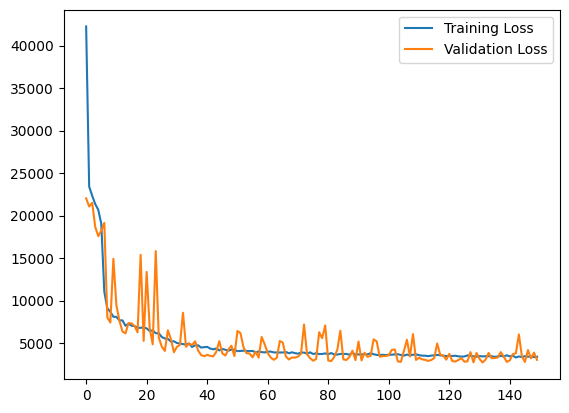

In [ ]:
# Define the number of nodes in the input and output layers
input_dim = 13
output_dim = 1

# Create the model
model = Sequential()
model.add(Dense(300, input_dim=input_dim, activation='relu'))
model.add(Dense(350, activation='relu'))
model.add(Dense(350, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(350, activation='relu'))
model.add(Dense(350, activation='relu'))
model.add(Dense(300, input_dim=input_dim, activation='relu'))
model.add(Dense(output_dim))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Scaling
df_zurich_scaled = df_zurich.copy()
df_zurich_scaled[cols_to_normalize] = scaler.fit_transform(df_zurich[cols_to_normalize])

# Train the model
X_train, X_val, y_train, y_val = train_test_split(df_zurich_scaled.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET']), df_zurich['IRRADIANCE'], test_size = 0.2, random_state = 42)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32, verbose=1)

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.show()

## Long-Short Term Memory Neural Network (LSTM)

In [ ]:
# Define the number of nodes in the input and output layers
input_dim = 13
output_dim = 1

# Reshape the input data for LSTM network
X_train, X_val, y_train, y_val = train_test_split(df_zurich.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET']), df_zurich['IRRADIANCE'], test_size = 0.2, random_state = 42)
X_train, X_val = X_train.values, X_val.values
y_train, y_val = y_train.values, y_val.values
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

# Create the model
model = Sequential()
model.add(LSTM(300, input_shape=(1, input_dim), activation='relu', return_sequences=True))
model.add(LSTM(300, activation='relu'))
model.add(Dense(output_dim))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and calculate training and validation loss
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

# Get the training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/100
1973/1973 [==============================] - 29s 11ms/step - loss: 24559.5840 - val_loss: 17314.5547
Epoch 2/100
1973/1973 [==============================] - 20s 10ms/step - loss: 12051.7119 - val_loss: 16863.6309
Epoch 3/100
1973/1973 [==============================] - 21s 11ms/step - loss: 10913.5449 - val_loss: 10143.5498
Epoch 4/100
1973/1973 [==============================] - 23s 12ms/step - loss: 10312.7734 - val_loss: 13979.2227
Epoch 5/100
1973/1973 [==============================] - 21s 11ms/step - loss: 8495.2949 - val_loss: 5624.1240
Epoch 6/100
1973/1973 [==============================] - 22s 11ms/step - loss: 5304.0146 - val_loss: 3600.7671
Epoch 7/100
1973/1973 [==============================] - 20s 10ms/step - loss: 4634.3057 - val_loss: 3719.8372
Epoch 8/100
1973/1973 [==============================] - 23s 12ms/step - loss: 4517.0405 - val_loss: 4159.9526
Epoch 9/100
1973/1973 [==============================] - 20s 10ms/step - loss: 4369.2412 - val_loss: 334

KeyboardInterrupt: ignored

In [ ]:
print(mse)

3711.879638671875


# "Quadrangulation" of Zurich Location

We will use the following 3 approaches:


*   Averaging the measured solar radiation in the 4 cities.
*   Ensembling the measured solar radiation in the 4 cities with different weights according to a similarity measure between Zurich climate and the other cities climates?
*   Training an model on a custom data set featuring information of all of the 4 cities.





## Averaging the measured solar radiation in the 4 cities

In [ ]:
y_pred = (df_dijon['IRRADIANCE'].values + df_milano['IRRADIANCE'].values + df_karlsruhe['IRRADIANCE'].values + df_innsbruck['IRRADIANCE'].values)/4
mse = mean_squared_error(df_zurich['IRRADIANCE'].values, y_pred)
print(mse)

1979.1531860066643


## Ensembling the measured solar radiation in the 4 cities with different weights according to a similarity measure between Zurich climate and the other cities climates?

### Defining a similarity measure, i.e., correlation among features between [Dijon, Milano, Karlsruhe, Innsbruck] and Zurich.

In [ ]:
df_zurich_sim = df_zurich.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE'])
df_dijon_sim = df_dijon.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE'])
df_karlsruhe_sim = df_karlsruhe.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE'])
df_milano_sim = df_milano.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE'])
df_innsbruck_sim = df_innsbruck.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE'])

In [ ]:
dfs = [df_dijon_sim, df_karlsruhe_sim, df_milano_sim, df_innsbruck_sim]
corr = [[], [], [], []]

for i, df in zip(range(4), dfs):
  for feature in ['TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE']:
    corr[i].append(df_zurich_sim[feature].corr(df[feature]))

In [ ]:
dijon_mean_corr = round(np.mean(corr[0]), 3)
karlsruhe_mean_corr = round(np.mean(corr[1]), 3)
milano_mean_corr = round(np.mean(corr[2]), 3)
innsbruck_mean_corr = round(np.mean(corr[3]), 3)
correlations = [('dijon', dijon_mean_corr), ('karlsruhe', karlsruhe_mean_corr), ('milano', milano_mean_corr), ('innsbruck', innsbruck_mean_corr)]
print(correlations)

[('dijon', 0.768), ('karlsruhe', 0.792), ('milano', 0.656), ('innsbruck', 0.764)]


### Scaling the correlations to obtain weights.

In [ ]:
total = dijon_mean_corr + karlsruhe_mean_corr + milano_mean_corr + innsbruck_mean_corr
dijon_norm = dijon_mean_corr / total
karlsruhe_norm = karlsruhe_mean_corr / total
milano_norm = milano_mean_corr / total
innsbruck_norm = innsbruck_mean_corr / total
print(dijon_norm, karlsruhe_norm, milano_norm, innsbruck_norm)

0.2577181208053691 0.2657718120805369 0.22013422818791945 0.25637583892617444


### Predicting Zurich Irradiance via an ensemble of the other 4 cities radiations with the weights calculated above. 

In [ ]:
y_pred = (dijon_norm * df_dijon['IRRADIANCE'].values + milano_norm * df_milano['IRRADIANCE'].values + karlsruhe_norm * df_karlsruhe['IRRADIANCE'].values + innsbruck_norm * df_innsbruck['IRRADIANCE'].values)
mse = mean_squared_error(df_zurich['IRRADIANCE'].values, y_pred)
print(mse)

1888.75399430857


### Which of the 4 neighboring locations has the most similar climate to Zurich? Does it also share the highest correlation in terms of solar radiation over time?

Karlsruhe has the most similar climate to zurich, with a mean correlation of the weather parameters of: 0.792. 
And, indeed, it shares also the highest correlation in terms of solar radiation over time, i.e., 0.974.

In [ ]:
irr_corr = []
for df in dfs:
  irr_corr.append(df_zurich_sim['IRRADIANCE'].corr(df['IRRADIANCE']))
print(irr_corr)

[0.9311058817068869, 0.9740924224256107, 0.9213114082055411, 0.9667764423839087]


## Training an model on a custom data set featuring information of all of the 4 cities.

In [ ]:
df_zurich_custom = df_zurich[['YEAR', 'MONTH', 'DAY', 'HOUR', 'IRRADIANCE']]
df_dijon_custom = df_dijon.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE']).rename(columns=lambda x: x + "_dijon")
df_karlsruhe_custom = df_karlsruhe.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE']).rename(columns=lambda x: x + "_karlsruhe")
df_milano_custom = df_milano.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE']).rename(columns=lambda x: x + "_milano")
df_innsbruck_custom = df_innsbruck.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE']).rename(columns=lambda x: x + "_innsbruck")

In [ ]:
df_custom = pd.concat([df_zurich_custom, df_dijon_custom, df_karlsruhe_custom, df_milano_custom, df_innsbruck_custom], axis=1, sort=False)

(LinearRegression) MSE: [-1253.78245019 -1294.55960624 -1305.45746511], Mean MSE: -1284.5998405145012
(KNeighborsRegressor) MSE: [-1291.07045428 -1315.62268374 -1369.13432309], Mean MSE: -1325.2758203718738
(XGBRegressor) MSE: [-870.18612628 -907.81835174 -917.23916274], Mean MSE: -898.4145469212705
(DecisionTreeRegressor) MSE: [-2234.68021715 -2341.76835051 -2381.97793971], Mean MSE: -2319.475502459183
(RandomForestRegressor) MSE: [-954.68058362 -988.49914758 -993.550704  ], Mean MSE: -978.9101450669647
(AdaBoostRegressor) MSE: [-1007.6532764  -1042.93188336 -1066.88161468], Mean MSE: -1039.1555914765238
(CatBoostRegressor) MSE: [-1152.01884455 -1186.76872998 -1191.04622401], Mean MSE: -1176.611266178644
(VotingRegressor) MSE: [-895.46725137 -928.38132998 -937.77492694], Mean MSE: -920.54116942907
(StackingRegressor) MSE: [-882.2362252  -917.38943035 -935.87127697], Mean MSE: -911.8323108403441

In [ ]:
regressors = [LinearRegression(),
              KNeighborsRegressor(n_neighbors=5, weights='distance'),
              XGBRegressor(subsample = 1.0, n_jobs = -1, n_estimators = 362, max_depth = 7, learning_rate = 0.06),
              DecisionTreeRegressor(),
              RandomForestRegressor(n_jobs = -1, n_estimators = 510, min_samples_split = 2, min_samples_leaf = 1, max_features = 5, max_depth = 19),
              AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42),
              CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, loss_function='RMSE', random_seed=42, verbose=0)]

X = df_custom.drop(columns=['IRRADIANCE'])
y = df_custom['IRRADIANCE']
cv = KFold(n_splits=3, shuffle=True, random_state=42)

for model in regressors:
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    print(f'({type(model).__name__}) MSE: {scores}, Mean MSE: {np.mean(scores)}')

(LinearRegression) MSE: [-1253.78245019 -1294.55960624 -1305.45746511], Mean MSE: -1284.5998405145012
(KNeighborsRegressor) MSE: [-1291.07045428 -1315.62268374 -1369.13432309], Mean MSE: -1325.2758203718738
(XGBRegressor) MSE: [-870.18612628 -907.81835174 -917.23916274], Mean MSE: -898.4145469212705
(DecisionTreeRegressor) MSE: [-2248.53225797 -2337.03724351 -2430.30132506], Mean MSE: -2338.6236088479873
(RandomForestRegressor) MSE: [-956.7550137  -990.75433159 -997.09568266], Mean MSE: -981.5350093175539
(AdaBoostRegressor) MSE: [-1007.6532764  -1042.93188336 -1066.88161468], Mean MSE: -1039.1555914765238
(CatBoostRegressor) MSE: [-1152.01884455 -1186.76872998 -1191.04622401], Mean MSE: -1176.611266178644


In [ ]:
xgb = XGBRegressor(subsample = 1.0, n_jobs = -1, n_estimators = 362, max_depth = 7, learning_rate = 0.06)
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 5, max_depth = 20)
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42)
elastic_net = ElasticNetCV()
estimators = [('xgb', xgb), ('rf', rf), ('abr', abr)] 

ensemble_models = [VotingRegressor(estimators, n_jobs=-1),
                   StackingRegressor(estimators, n_jobs=-1),
                   StackingRegressor(estimators, elastic_net, n_jobs=-1)]

X = df_custom.drop(columns=['IRRADIANCE'])
y = df_custom['IRRADIANCE']
cv = KFold(n_splits=3, shuffle=True, random_state=42)

for model in ensemble_models:
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    print(f'({type(model).__name__}) MSE: {scores}, Mean MSE: {np.mean(scores)}')

(VotingRegressor) MSE: [-891.93156325 -931.33290753 -944.09446848], Mean MSE: -922.452979753651
(StackingRegressor) MSE: [-879.76029455 -919.73064061 -935.65928826], Mean MSE: -911.7167411433021
(StackingRegressor) MSE: [-883.20237365           nan           nan], Mean MSE: nan


(VotingRegressor) MSE: [-891.93156325 -931.33290753 -944.09446848], Mean MSE: -922.452979753651

(StackingRegressor) MSE: [-879.76029455 -919.73064061 -935.65928826], Mean MSE: -911.7167411433021

(StackingRegressor) MSE: [-883.20237365           nan           nan], Mean MSE: nan